In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial.distance import cosine

In [2]:
# define a plotting function, taken from matplotlib example library
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=0.15, aspect=6.2)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [3]:
df = pd.read_csv('Datasets/PTEN_MCF10A.csv', index_col=False)

In [4]:
print(df)

   variant  MCF10A score  std_dev  std_err
0      K6E        0.3311  0.06073  0.03506
1      K6I        0.4544  0.04539  0.02621
2     R15S        0.3870  0.05989  0.03458
3     M35V        0.3606  0.08549  0.04936
4     P38H        0.3521  0.10320  0.05958
5     G44D        0.6232  0.02915  0.01683
6     A79T        0.5711  0.03582  0.02068
7     D92N        0.2677  0.07449  0.04300
8     H93Q        0.3301  0.11380  0.06572
9     H93R        0.3930  0.10080  0.05820
10   I101F        0.8803  0.07377  0.04259
11   I101T        0.7138  0.29600  0.17090
12   N117S        0.4916  0.04733  0.02732
13   H123Y        0.6383  0.03563  0.02057
14   H123Q        0.9934  0.23610  0.13630
15   C124S        0.8797  0.08238  0.04756
16   C124R        0.6986  0.06995  0.04039
17   A126D        0.5325  0.04679  0.02701
18   G127R        0.9753  0.06603  0.03812
19   G129R        0.8214  0.08842  0.05105
20   G129E        0.8841  0.09365  0.05407
21   R130L        0.4728  0.06297  0.03636
22   R130P 

In [5]:
# now generate a new df to plot heatmap
df_toplot = df[['variant','MCF10A score']].transpose()
df_toplot.columns = df_toplot.iloc[0]

# remove the extra row that shows variants
df_toplot = df_toplot.drop(df_toplot.index[0])

# during transpose, dtype was changed. change it back
df_toplot = df_toplot[df_toplot.columns].astype(float)

In [6]:
# this will modify the range of the colormap by truncation
# https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [7]:
cmap = plt.get_cmap('Reds') 
new_cmap = truncate_colormap(cmap, 0.0, 0.8)

In [8]:
fig, ax = plt.subplots(figsize= (15,15), dpi=200)

im, cbar = heatmap(df_toplot, 'MCF10A score', df_toplot.columns, ax=ax,
                   cmap=new_cmap, cbarlabel="MCF10A score")

fig.tight_layout()

# output figure
mpl.rcParams['pdf.fonttype'] = 42
plt.savefig("PTEN_MCF10A_heatmap.pdf", transparent=True)

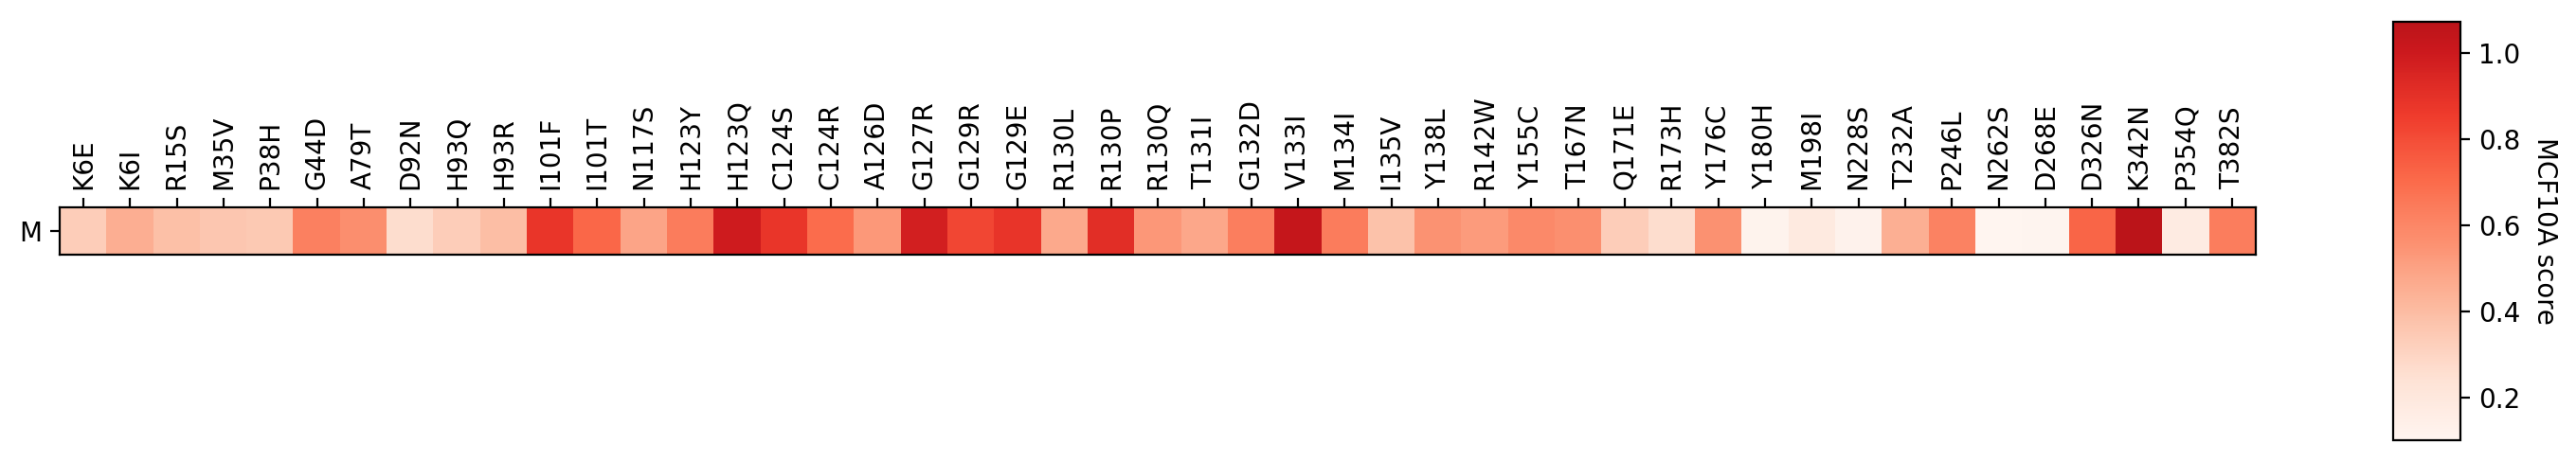

In [9]:
plt.show()